In [1]:
import torch
import os
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pandas as pd
cudnn.benchmark = True  # fire on all cylinders
from sklearn.metrics import roc_auc_score, roc_curve
import sys
from torchvision import datasets, transforms as T 
import seaborn as sns

sys.path.insert(0, '..')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import utils

## Preparation

In [2]:
dataset_path = '../../tdc_datasets'
task = 'detection'
MODEL_FILEDIR = os.path.join(dataset_path, task, 'train')
EXTRACTED_DIR = './extracted_features'
NUM_MODEL = 500
model_classes = ['MNIST_Network', 'SimpleViT']
clean_or_trojan = ['clean', 'trojan']

def num_to_model_id(num):
    return 'id-' + str(10000+num)[1:]

In [3]:
MODEL_SPEC_DICT = {'MNIST_Network': (1, 28, range(375, 500), 10), 
                    'SimpleViT': (3, 32, range(250, 375), 43)}
                    # 'Model type (dataset type)': (num of channels, resolution, model id range, num of classes)

In [4]:
def set_seed(seed=0):
    """Set one seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Load Dataset

In [5]:
mnist_train, _, _ = utils.load_data('MNIST')
vit_train, _, _ = utils.load_data('GTSRB')
# DATASET_DICT = {'mnist': mnist_train, 'vit': vit_train}

In [6]:
def dataset_dict_filtered_by_label(dataset, num_classes, num_datapt_per_class=20):
    cnt = [0]*num_classes
    ret_dict = {i:[] for i in range(num_classes)}
    for img, label in dataset:
        if all(cnt[ind] == num_datapt_per_class for ind in range(num_classes)):
            break
        if cnt[label] < num_datapt_per_class:
            ret_dict[label].append(img)
            cnt[label] += 1
    for k, v in ret_dict.items():
        ret_dict[k] = torch.stack(v, dim=0)
    return ret_dict

In [7]:
mnist_filtered_ds = dataset_dict_filtered_by_label(mnist_train, 10, 20)

## Trigger Injection

In [8]:
def generate_images_with_trigger(images, seed=1, type='generic'):
    rng = np.random.default_rng(seed)
    masks = torch.from_numpy(rng.uniform(0, 1, size=[images.shape[0], 1, images.shape[-2], images.shape[-1]]).astype(np.float32))
    pattern = torch.from_numpy(rng.uniform(0, 1, size=images.shape).astype(np.float32))
    return (1 - masks) * images + masks * pattern, masks, pattern

In [9]:
mnist_ds_with_trigger = {k: generate_images_with_trigger(mnist_filtered_ds[k])[0] for k in mnist_filtered_ds.keys()}

## Prediction from Models

In [10]:
import torch.nn.functional as F

In [11]:
MODEL_DIR = os.path.join(dataset_path, task, 'train', 'clean')
SAMPLE_MODEL_DICT = {cot:torch.load(os.path.join(MODEL_DIR, num_to_model_id(375), 'model.pt')) for cot in clean_or_trojan}

In [25]:
LAMBD = .03
STEP = 200
TRIGGER_DICT = {}

In [26]:
for cot in clean_or_trojan:
    model = SAMPLE_MODEL_DICT[cot]
    model.eval()

    for lbl in tqdm(range(10)):
        labels = list(range(10))
        labels.pop(lbl)

        mnist_original_input = torch.concat([mnist_filtered_ds[l] for l in labels], dim=0)
        _, masks, patterns = generate_images_with_trigger(mnist_original_input)
        masks, patterns = masks.requires_grad_(), patterns.requires_grad_()
        optimizer = torch.optim.Adam([patterns, masks], lr=.01, betas=(.5, .9))
        mnist_original_input = mnist_original_input.requires_grad_()

        for step in range(STEP):
            optimizer.zero_grad()
            mnist_sample_input =  (1 - masks) * mnist_original_input + masks * patterns
            mnist_sample_input.retain_grad()
            mnist_sample_pred = model(mnist_sample_input)

            loss = F.cross_entropy(mnist_sample_pred, torch.tensor([lbl]*mnist_sample_input.shape[0]))
            loss_reg = torch.sum(torch.abs(masks)) * LAMBD
            total_loss = loss + loss_reg
            total_loss.backward()
            optimizer.step()

        TRIGGER_DICT[cot+'_'+str(lbl)] = (masks, patterns)
        


100%|██████████| 10/10 [56:28<00:00, 338.82s/it]


In [64]:
OUTPUT_TRIGGER_DICT = TRIGGER_DICT
for k, v in OUTPUT_TRIGGER_DICT.items():
    OUTPUT_TRIGGER_DICT[k] = (v[0].tolist(), v[1].tolist())

In [69]:
with open(os.path.join(EXTRACTED_DIR, 'trigger_dict.json'), 'w') as outfile:
    json.dump(OUTPUT_TRIGGER_DICT, outfile)

In [55]:
import torchvision.transforms as T
import torchvision
transform = T.ToPILImage()

GRID_KEYS = ['masks', 'patterns', 'triggers']
GRID_DICT = {k:[] for k in GRID_KEYS}
for cot in clean_or_trojan:
    small_grid_dict = {k:[] for k in GRID_KEYS}
    for i in range(10):
        m, p = TRIGGER_DICT[cot+'_'+str(i)]
        for k, v in list(zip(GRID_KEYS, [m, p, m*p])):
            img = torch.mean(v, dim=0)
            norm_img = (img - img.min())/(img.max()-img.min())
            small_grid_dict[k].append(norm_img)
    for k, v in small_grid_dict.items():
        grid = torchvision.utils.make_grid(v, nrow=5)
        GRID_DICT[k].append(grid)

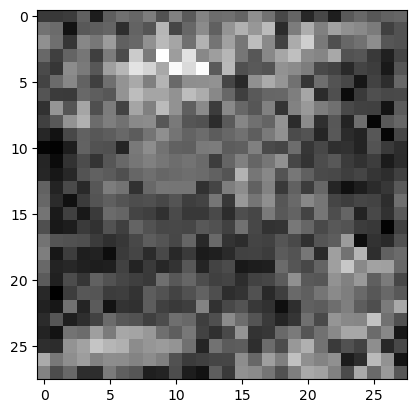

In [54]:
test = torch.mean(p, dim=0).detach().numpy()
norm_test = (test - test.min())/(test.max()-test.min())
plt.imshow(np.transpose(np.concatenate([norm_test]*3, axis=0), (1,2,0)), interpolation='nearest')

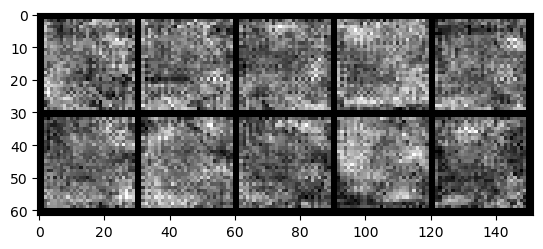

In [58]:
img = GRID_DICT['patterns'][0].numpy()
plt.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')

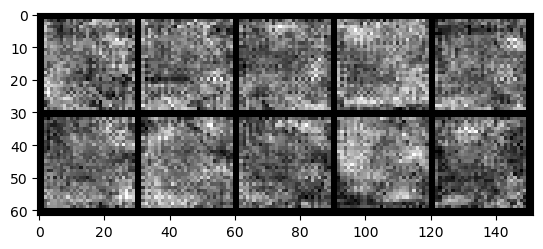

In [59]:
img = GRID_DICT['patterns'][1].numpy()
plt.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')